In [19]:
# Step 1.Importing Libraries and Reading Dataset

# Importing libraries and reading dataset
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as plt
from sklearn.model_selection import train_test_split,RandomizedSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

file_path = "/content/dataset.csv"
data = pd.read_csv(file_path)
data

,hour_of_day,day_of_week,month,holiday,weekday,summertime,temp,dew,humidity,precip,snow,snowdepth,windspeed,cloudcover,visibility,increase_stock
0,5,5,1,0,0,0,-7.2,-15.0,53.68,0.000,0,0.0,16.3,31.6,16.0,low_bike_demand
1,21,4,1,0,1,0,-1.3,-12.8,40.97,0.000,0,0.0,23.9,85.7,16.0,low_bike_demand
2,21,3,8,0,1,1,26.9,21.8,73.39,0.000,0,0.0,0.0,81.1,16.0,low_bike_demand
3,1,6,1,0,0,0,3.1,-4.0,59.74,0.000,0,0.0,19.2,0.0,16.0,low_bike_demand
4,17,0,3,0,1,0,11.7,-11.4,18.71,0.000,0,0.0,10.5,44.6,16.0,low_bike_demand
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,3,5,6,0,0,1,21.5,19.4,87.68,0.000,0,0.0,10.6,24.4,16.0,low_bike_demand
1596,14,0,6,0,1,1,23.2,20.1,82.43,2.217,0,0.0,9.8,92.1,10.4,low_bike_demand
1597,13,0,3,0,1,1,13.9,-2.2,32.93,0.000,0,2.0,18.2,79.3,16.0,low_bike_demand
1598,14,5,3,0,0,1,11.7,-9.3,22.09,0.000,0,0.0,5.8,24.4,16.0,high_bike_demand


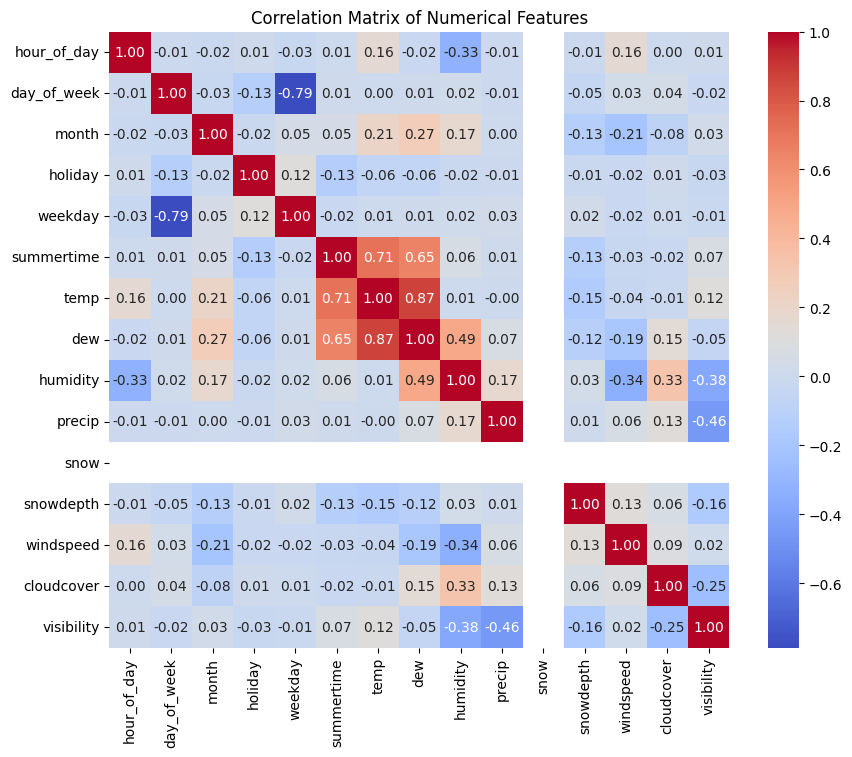

In [20]:
# Reloading the dataset to analyze correlations, outliers, and range of values
import matplotlib.pyplot as plt

# Ensure numerical columns are selected
numerical_data = data.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
correlation_matrix = numerical_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# Encoding categorical data
data['increase_stock_encoded'] = data['increase_stock'].map({'low_bike_demand': 0, 'high_bike_demand': 1})
# Re-run correlation analysis with the new encoded column

# Identifying outliers using boxplot for key features
numerical_features = data.select_dtypes(include=['float64', 'int64']).columns

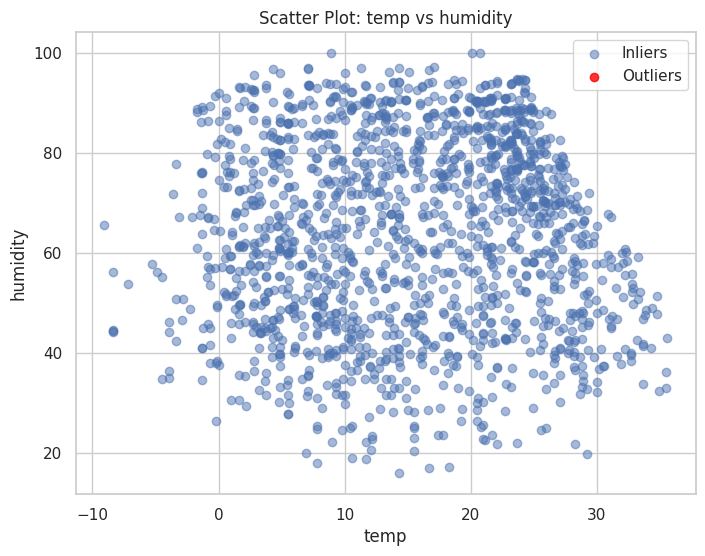

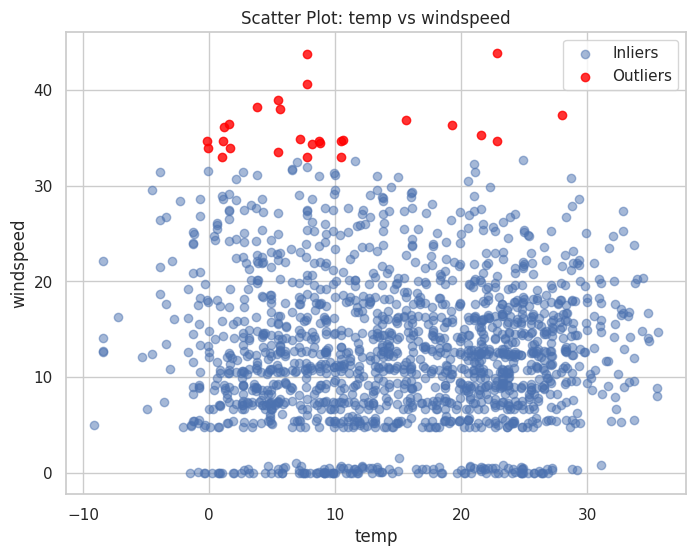

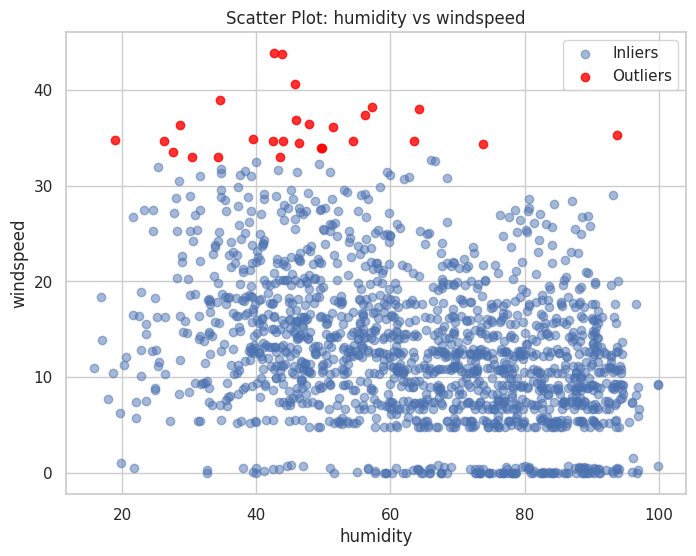

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Function to detect outliers using the IQR method
def detect_outliers(column):
    Q1 = np.percentile(column, 25)
    Q3 = np.percentile(column, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (column < lower_bound) | (column > upper_bound)

# Define the columns you want to use for scatter plots
# Replace 'total_count' with the actual name of your count column
# in the DataFrame
# The original code used 'cnt', but based on the DataFrame structure,
# it's likely the column is named 'total_count'.
selected_columns = ['temp', 'humidity', 'windspeed']

# Generate scatter plots with highlighted outliers
for i in range(len(selected_columns)):
    for j in range(i + 1, len(selected_columns)):
        x = data[selected_columns[i]]
        y = data[selected_columns[j]]

        # Detect outliers for both axes
        x_outliers = detect_outliers(x)
        y_outliers = detect_outliers(y)

        # Combine outlier conditions
        outliers = x_outliers | y_outliers

        plt.figure(figsize=(8, 6))
        plt.scatter(x[~outliers], y[~outliers], alpha=0.5, label='Inliers')
        plt.scatter(x[outliers], y[outliers], color='red', alpha=0.8, label='Outliers')
        plt.title(f"Scatter Plot: {selected_columns[i]} vs {selected_columns[j]}")
        plt.xlabel(selected_columns[i])
        plt.ylabel(selected_columns[j])
        plt.legend()
        plt.grid(True)
    plt.show()

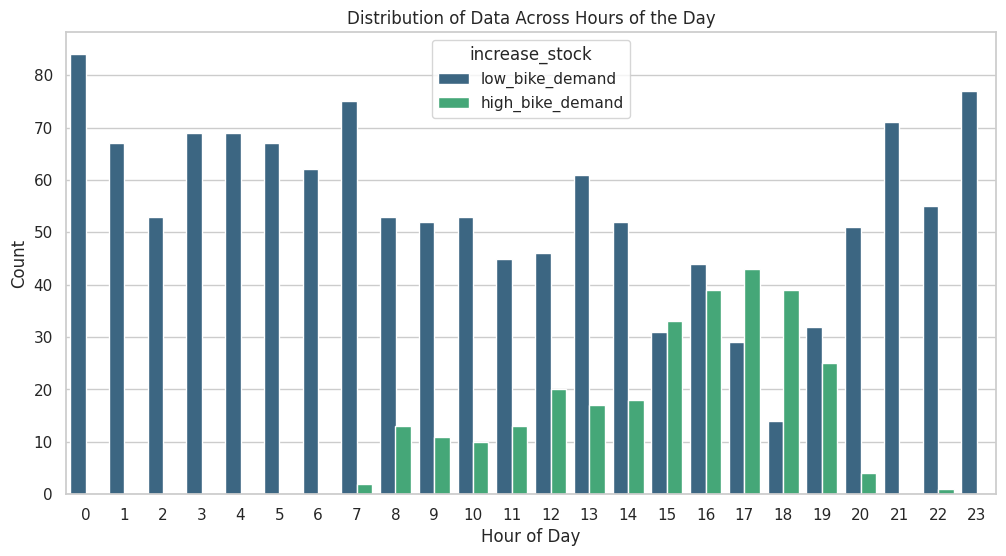

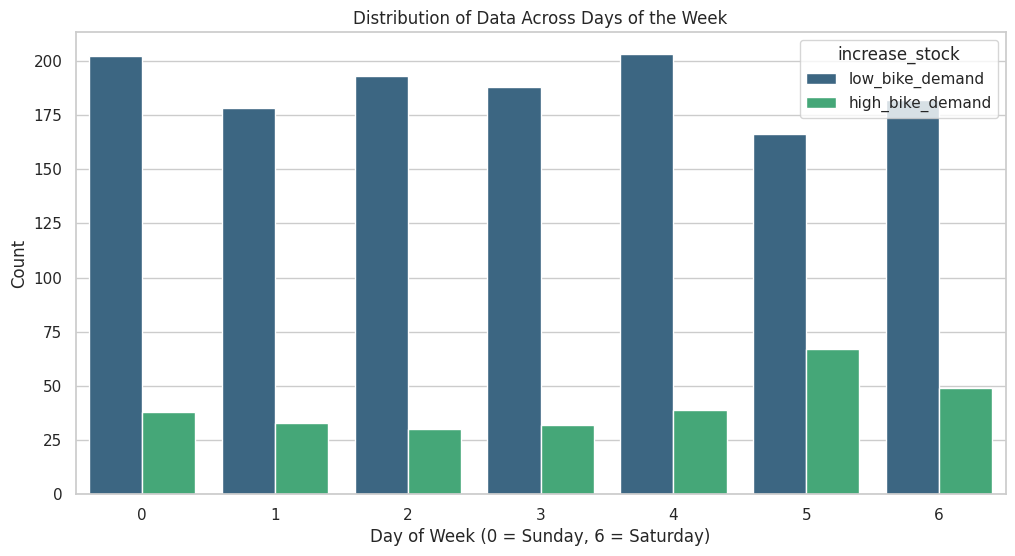

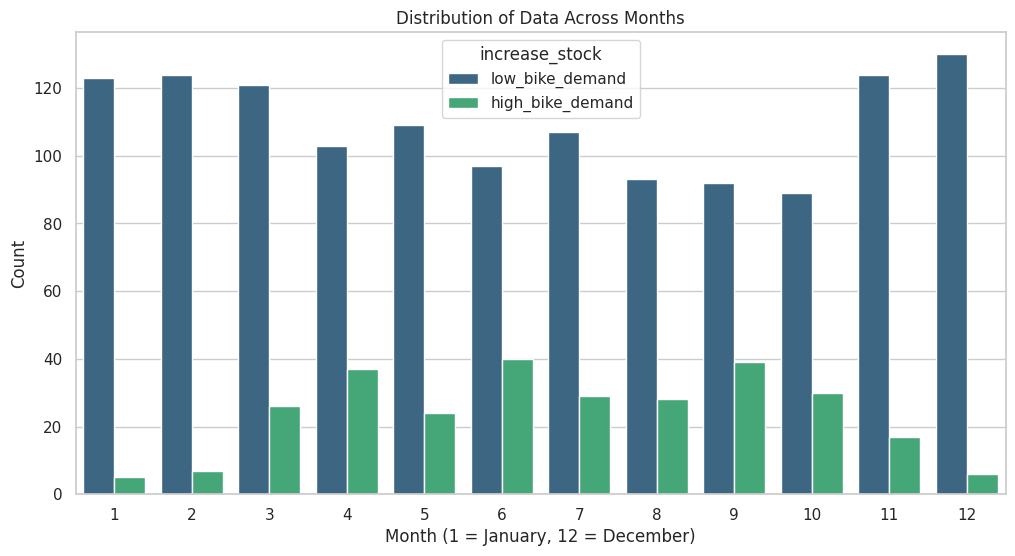

In [54]:
import seaborn as sns

# Counterplot for hour_of_day
plt.figure(figsize=(12, 6))
sns.countplot(x='hour_of_day', data=data,hue='increase_stock', palette="viridis")
plt.title("Distribution of Data Across Hours of the Day")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.show()

# Counterplot for day_of_week
plt.figure(figsize=(12, 6))
sns.countplot(x='day_of_week', data=data,hue='increase_stock', palette="viridis")
plt.title("Distribution of Data Across Days of the Week")
plt.xlabel("Day of Week (0 = Sunday, 6 = Saturday)")
plt.ylabel("Count")
plt.show()

# Counterplot for month
plt.figure(figsize=(12, 6))
sns.countplot(x='month', data=data,hue='increase_stock', palette="viridis")
plt.title("Distribution of Data Across Months")
plt.xlabel("Month (1 = January, 12 = December)")
plt.ylabel("Count")
plt.show()

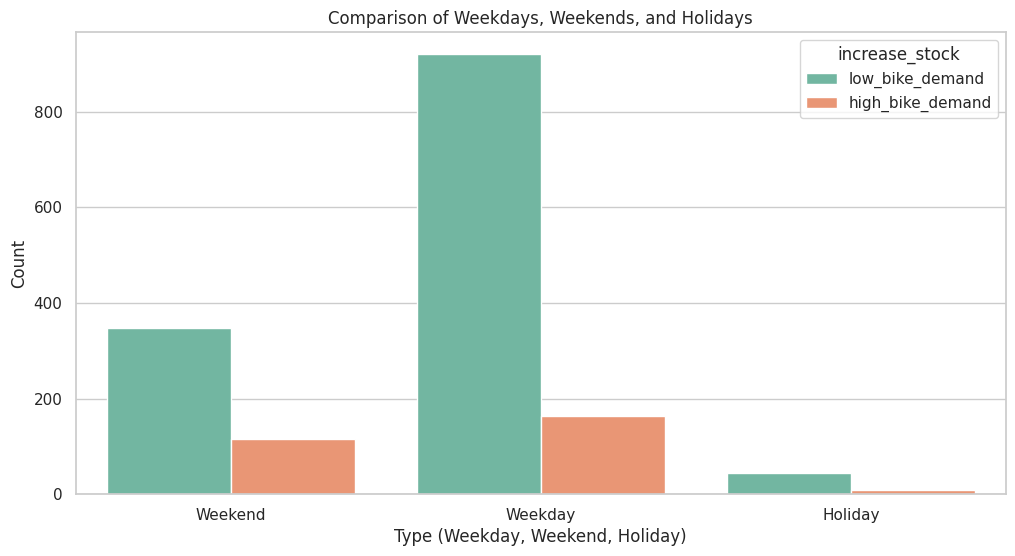

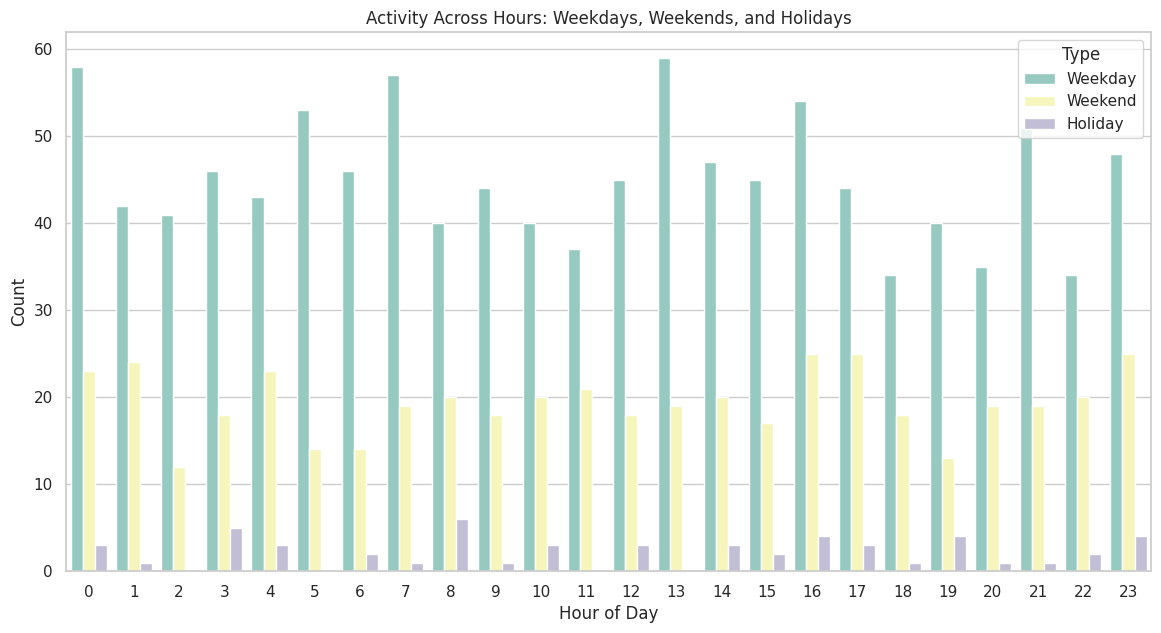

In [55]:
# Create a column combining weekday and holiday information for comparison
data['weekday_holiday'] = data.apply(
    lambda row: 'Holiday' if row['holiday'] == 1 else 'Weekday' if row['weekday'] == 1 else 'Weekend',
    axis=1
)

# Count plot for the 'weekday_holiday' column
plt.figure(figsize=(12, 6))
sns.countplot(x='weekday_holiday',hue='increase_stock', data=data, palette="Set2")
plt.title("Comparison of Weekdays, Weekends, and Holidays")
plt.xlabel("Type (Weekday, Weekend, Holiday)")
plt.ylabel("Count")
plt.show()

# Analyzing by hour to see patterns during holidays vs weekdays
plt.figure(figsize=(14, 7))
sns.countplot(x='hour_of_day', hue='weekday_holiday', data=data, palette="Set3")
plt.title("Activity Across Hours: Weekdays, Weekends, and Holidays")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.legend(title="Type")
plt.show()

<ipython-input-56-4ca3b44a841b>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='weather_condition', data=data, palette="coolwarm")


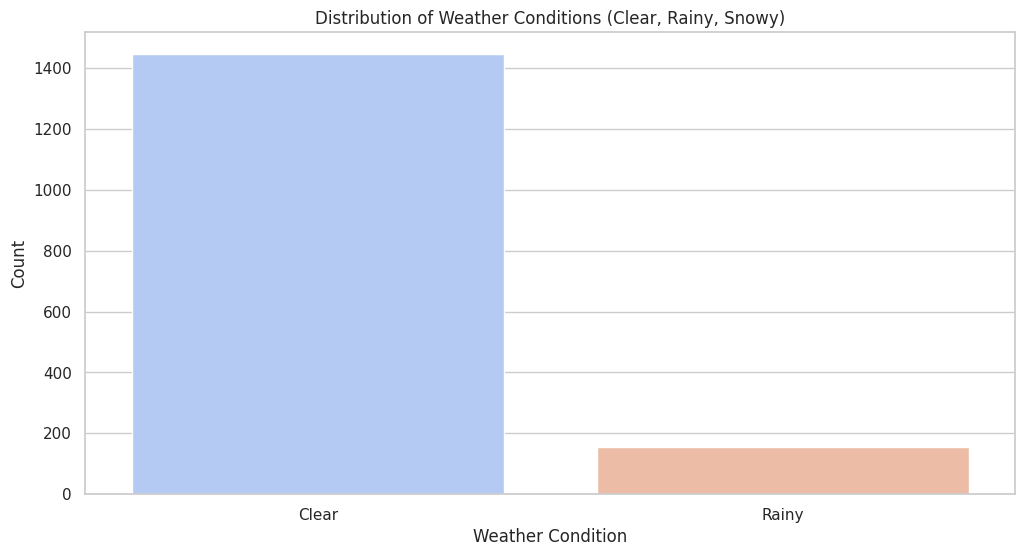

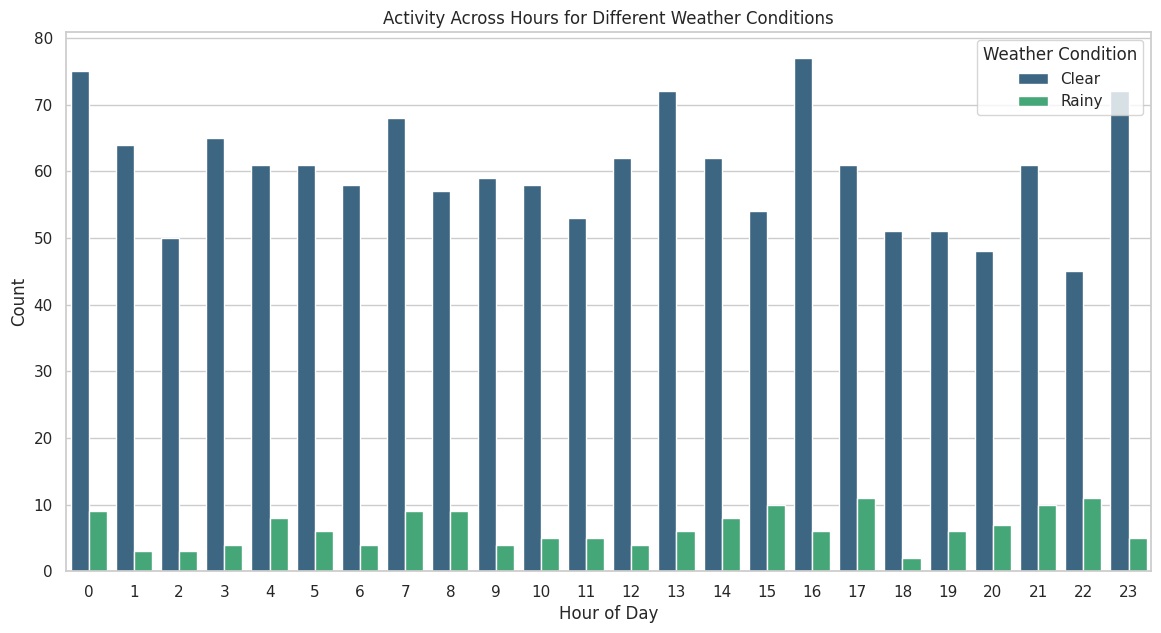

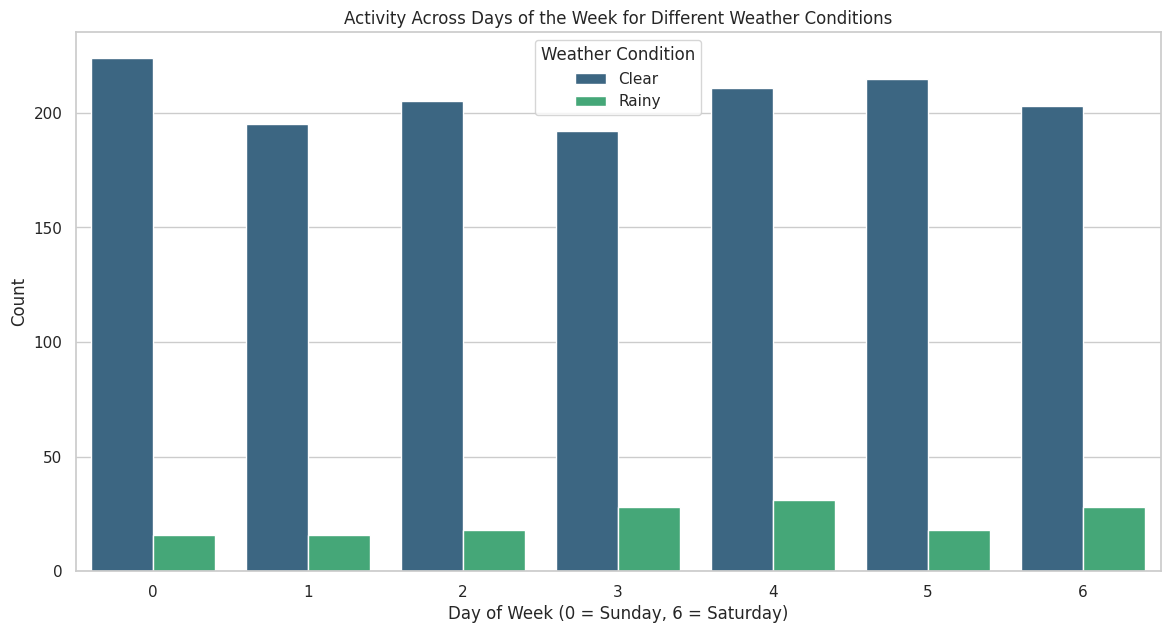

In [56]:
# Create a column to categorize weather conditions
data['weather_condition'] = data.apply(
    lambda row: 'Snowy' if row['snow'] > 0 else 'Rainy' if row['precip'] > 0 else 'Clear',
    axis=1
)

# Count plot for weather conditions
plt.figure(figsize=(12, 6))
sns.countplot(x='weather_condition', data=data, palette="coolwarm")
plt.title("Distribution of Weather Conditions (Clear, Rainy, Snowy)")
plt.xlabel("Weather Condition")
plt.ylabel("Count")
plt.show()

# Analyzing hourly trends for different weather conditions
plt.figure(figsize=(14, 7))
sns.countplot(x='hour_of_day', hue='weather_condition', data=data, palette="viridis")
plt.title("Activity Across Hours for Different Weather Conditions")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.legend(title="Weather Condition")
plt.show()

# Analyzing weekday trends for different weather conditions
plt.figure(figsize=(14, 7))
sns.countplot(x='day_of_week', hue='weather_condition', data=data, palette="viridis")
plt.title("Activity Across Days of the Week for Different Weather Conditions")
plt.xlabel("Day of Week (0 = Sunday, 6 = Saturday)")
plt.ylabel("Count")
plt.legend(title="Weather Condition")
plt.show()